# Process Image

(335, 64, 64, 3) 1.0 0.0
0.984313725490196 0.0


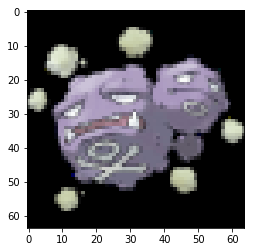

In [37]:
import os
import numpy as np
import matplotlib.image as im
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

%matplotlib inline

IMAGE_DIR = './pokemon'

images = []

for filename in os.listdir(IMAGE_DIR):
    filepath = os.path.join(IMAGE_DIR, filename)
    cur_im = Image.open(filepath)
    cur_im = cur_im.resize((64,64),4)
    images.append(np.array(cur_im)[:,:,:-1])
    
images = np.array(images)
images = images / 255.
print(images.shape, images.max(), images.min())

# RECOVER
im = images[10]
print(im.max(), im.min())
plt.imshow(im)

def get_batch(images, batch_size, shuffle=True, repeat=1):
    if shuffle:
        np.random.shuffle(images)
    n_batch = len(images) // batch_size
    
    for i in range(n_batch):
        batch_images = []
        cand_images = images[i*batch_size:(i+1)*batch_size, :, :, :]
        for j in range(len(cand_images)):
            for _ in range(repeat):
                batch_images.append(cand_images[j])
            
        batch_images = np.array(batch_images)
        
        yield batch_images, np.ones((len(batch_images),1))

# Build Generator and Discriminator

In [3]:
def gen(z, reuse=False, train=True):
    with tf.variable_scope('gen', reuse=reuse):
        full = tf.layers.dense(z, fake_im_ori)
        hidden_1 = tf.reshape(full, (-1, *fake_im_dim))
        
        dconv_1 = tf.layers.conv2d_transpose(hidden_1, 256, 5, [2,2], 'SAME')
        dconv_1 = tf.layers.batch_normalization(dconv_1, training=train)
        dconv_1 = leaky_relu(dconv_1)
        
        dconv_2 = tf.layers.conv2d_transpose(dconv_1, 128, 5, [2,2], 'SAME')
        dconv_2 = tf.layers.batch_normalization(dconv_2, training=train)
        dconv_2 = leaky_relu(dconv_2)
        
        dconv_3 = tf.layers.conv2d_transpose(dconv_2, 3, 5, [2,2], 'SAME')
        dconv_3 = tf.layers.batch_normalization(dconv_3, training=train)
        dconv_3 = leaky_relu(dconv_3)
        
    return tf.nn.tanh(dconv_3)

def disc(im_arr, reuse=False):
    with tf.variable_scope('disc', reuse=reuse):
        conv_1 = tf.layers.conv2d(im_arr, 128, 5, 2, 'SAME')
        conv_1 = tf.layers.batch_normalization(conv_1, training=True)
        conv_1 = leaky_relu(conv_1)
        
        conv_2 = tf.layers.conv2d(conv_1, 256, 5, 2, 'SAME')
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        conv_2 = leaky_relu(conv_2)
        
        conv_3 = tf.layers.conv2d(conv_2, 512, 5, 2, 'SAME')
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        conv_3 = leaky_relu(conv_3)
        
        flatten = tf.reshape(conv_3, shape=(-1, fake_im_ori))
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)
        
    return logits, output

# Hyper Parameters

In [ ]:
leaky_alpha = 0.2
learning_rate = 2e-4
batch_size = 64
item_repeat = 1
fake_im_ori = 8*8*512
fake_im_dim = [8,8,512]
noise_dim = 100
n_batch = len(images) // batch_size
n_epochs = 5000
leaky_relu = lambda x: tf.maximum(x, x*leaky_alpha)
view_for_every = 1000
beta1 = 0.5

CK_DIR = './checkpoint/'
OUTPUT_DIR = './output/'

continuous = False 

To re-train network from very beginning, set `continuous` to `False`.

Because of file limitation of github, all checkpoint files are removed. But you can run all the code to train it yourself.

# Build the Graph

In [ ]:
tf.reset_default_graph()

z = tf.placeholder(tf.float32, [None, noise_dim])
y_ones = tf.placeholder(tf.float32, [batch_size*item_repeat, 1])
y_zeros = tf.placeholder(tf.float32, [batch_size*item_repeat, 1])
real_image = tf.placeholder(tf.float32, [None, 64, 64, 3])

fake_image = gen(z)

real_logits, real_output = disc(real_image)
fake_logits, fake_output = disc(fake_image, reuse=True)


fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=y_zeros))
real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=y_ones))
disc_logits = tf.concat([fake_logits, real_logits], axis=0)
disc_labels = tf.concat([y_zeros, y_ones], axis=0)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits, labels=disc_labels))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='gen')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='disc')

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    gen_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)
    disc_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(disc_loss, var_list=disc_vars)

# Train the Graph

EPOCH:1 EPOCH:2 EPOCH:3 EPOCH:4 EPOCH:5 EPOCH:6 EPOCH:7 EPOCH:8 EPOCH:9 EPOCH:10 EPOCH:11 EPOCH:12 EPOCH:13 EPOCH:14 EPOCH:15 EPOCH:16 EPOCH:17 EPOCH:18 EPOCH:19 EPOCH:20 EPOCH:21 EPOCH:22 EPOCH:23 EPOCH:24 EPOCH:25 EPOCH:26 EPOCH:27 EPOCH:28 EPOCH:29 EPOCH:30 EPOCH:31 EPOCH:32 EPOCH:33 EPOCH:34 EPOCH:35 EPOCH:36 EPOCH:37 EPOCH:38 EPOCH:39 EPOCH:40 EPOCH:41 EPOCH:42 EPOCH:43 EPOCH:44 EPOCH:45 EPOCH:46 EPOCH:47 EPOCH:48 EPOCH:49 EPOCH:50 EPOCH:51 EPOCH:52 EPOCH:53 EPOCH:54 EPOCH:55 EPOCH:56 EPOCH:57 EPOCH:58 EPOCH:59 EPOCH:60 EPOCH:61 EPOCH:62 EPOCH:63 EPOCH:64 EPOCH:65 EPOCH:66 EPOCH:67 EPOCH:68 EPOCH:69 EPOCH:70 EPOCH:71 EPOCH:72 EPOCH:73 EPOCH:74 EPOCH:75 EPOCH:76 EPOCH:77 EPOCH:78 EPOCH:79 EPOCH:80 EPOCH:81 EPOCH:82 EPOCH:83 EPOCH:84 EPOCH:85 EPOCH:86 EPOCH:87 EPOCH:88 EPOCH:89 EPOCH:90 EPOCH:91 EPOCH:92 EPOCH:93 EPOCH:94 EPOCH:95 EPOCH:96 EPOCH:97 EPOCH:98 EPOCH:99 EPOCH:100 EPOCH:101 EPOCH:102 EPOCH:103 EPOCH:104 EPOCH:105 EPOCH:106 EPOCH:107 EPOCH:108 EPOCH:109 EPOCH:110 EPOCH:11

EPOCH:832 EPOCH:833 EPOCH:834 EPOCH:835 EPOCH:836 EPOCH:837 EPOCH:838 EPOCH:839 EPOCH:840 EPOCH:841 EPOCH:842 EPOCH:843 EPOCH:844 EPOCH:845 EPOCH:846 EPOCH:847 EPOCH:848 EPOCH:849 EPOCH:850 EPOCH:851 EPOCH:852 EPOCH:853 EPOCH:854 EPOCH:855 EPOCH:856 EPOCH:857 EPOCH:858 EPOCH:859 EPOCH:860 EPOCH:861 EPOCH:862 EPOCH:863 EPOCH:864 EPOCH:865 EPOCH:866 EPOCH:867 EPOCH:868 EPOCH:869 EPOCH:870 EPOCH:871 EPOCH:872 EPOCH:873 EPOCH:874 EPOCH:875 EPOCH:876 EPOCH:877 EPOCH:878 EPOCH:879 EPOCH:880 EPOCH:881 EPOCH:882 EPOCH:883 EPOCH:884 EPOCH:885 EPOCH:886 EPOCH:887 EPOCH:888 EPOCH:889 EPOCH:890 EPOCH:891 EPOCH:892 EPOCH:893 EPOCH:894 EPOCH:895 EPOCH:896 EPOCH:897 EPOCH:898 EPOCH:899 EPOCH:900 EPOCH:901 EPOCH:902 EPOCH:903 EPOCH:904 EPOCH:905 EPOCH:906 EPOCH:907 EPOCH:908 EPOCH:909 EPOCH:910 EPOCH:911 EPOCH:912 EPOCH:913 EPOCH:914 EPOCH:915 EPOCH:916 EPOCH:917 EPOCH:918 EPOCH:919 EPOCH:920 EPOCH:921 EPOCH:922 EPOCH:923 EPOCH:924 EPOCH:925 EPOCH:926 EPOCH:927 EPOCH:928 EPOCH:929 EPOCH:930 EPOCH:931 

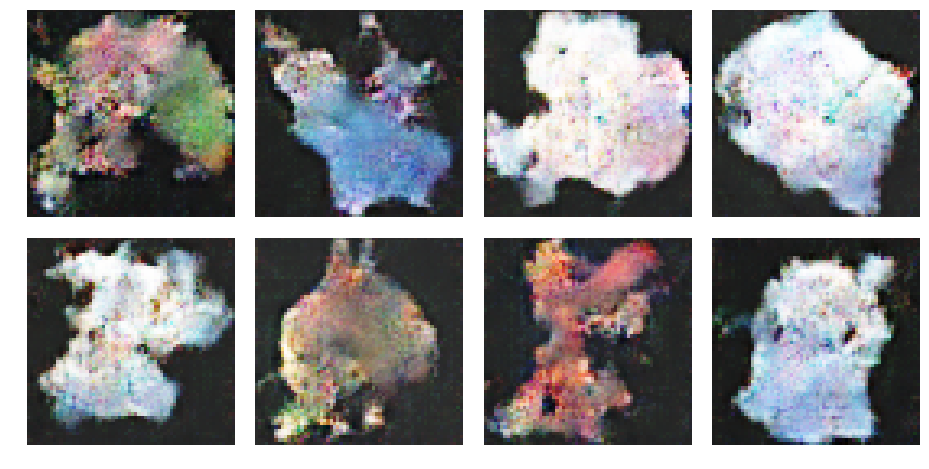

EPOCH:1001 EPOCH:1002 EPOCH:1003 EPOCH:1004 EPOCH:1005 EPOCH:1006 EPOCH:1007 EPOCH:1008 EPOCH:1009 EPOCH:1010 EPOCH:1011 EPOCH:1012 EPOCH:1013 EPOCH:1014 EPOCH:1015 EPOCH:1016 EPOCH:1017 EPOCH:1018 EPOCH:1019 EPOCH:1020 EPOCH:1021 EPOCH:1022 EPOCH:1023 EPOCH:1024 EPOCH:1025 EPOCH:1026 EPOCH:1027 EPOCH:1028 EPOCH:1029 EPOCH:1030 EPOCH:1031 EPOCH:1032 EPOCH:1033 EPOCH:1034 EPOCH:1035 EPOCH:1036 EPOCH:1037 EPOCH:1038 EPOCH:1039 EPOCH:1040 EPOCH:1041 EPOCH:1042 EPOCH:1043 EPOCH:1044 EPOCH:1045 EPOCH:1046 EPOCH:1047 EPOCH:1048 EPOCH:1049 EPOCH:1050 EPOCH:1051 EPOCH:1052 EPOCH:1053 EPOCH:1054 EPOCH:1055 EPOCH:1056 EPOCH:1057 EPOCH:1058 EPOCH:1059 EPOCH:1060 EPOCH:1061 EPOCH:1062 EPOCH:1063 EPOCH:1064 EPOCH:1065 EPOCH:1066 EPOCH:1067 EPOCH:1068 EPOCH:1069 EPOCH:1070 EPOCH:1071 EPOCH:1072 EPOCH:1073 EPOCH:1074 EPOCH:1075 EPOCH:1076 EPOCH:1077 EPOCH:1078 EPOCH:1079 EPOCH:1080 EPOCH:1081 EPOCH:1082 EPOCH:1083 EPOCH:1084 EPOCH:1085 EPOCH:1086 EPOCH:1087 EPOCH:1088 EPOCH:1089 EPOCH:1090 EPOCH:1091

EPOCH:1746 EPOCH:1747 EPOCH:1748 EPOCH:1749 EPOCH:1750 EPOCH:1751 EPOCH:1752 EPOCH:1753 EPOCH:1754 EPOCH:1755 EPOCH:1756 EPOCH:1757 EPOCH:1758 EPOCH:1759 EPOCH:1760 EPOCH:1761 EPOCH:1762 EPOCH:1763 EPOCH:1764 EPOCH:1765 EPOCH:1766 EPOCH:1767 EPOCH:1768 EPOCH:1769 EPOCH:1770 EPOCH:1771 EPOCH:1772 EPOCH:1773 EPOCH:1774 EPOCH:1775 EPOCH:1776 EPOCH:1777 EPOCH:1778 EPOCH:1779 EPOCH:1780 EPOCH:1781 EPOCH:1782 EPOCH:1783 EPOCH:1784 EPOCH:1785 EPOCH:1786 EPOCH:1787 EPOCH:1788 EPOCH:1789 EPOCH:1790 EPOCH:1791 EPOCH:1792 EPOCH:1793 EPOCH:1794 EPOCH:1795 EPOCH:1796 EPOCH:1797 EPOCH:1798 EPOCH:1799 EPOCH:1800 EPOCH:1801 EPOCH:1802 EPOCH:1803 EPOCH:1804 EPOCH:1805 EPOCH:1806 EPOCH:1807 EPOCH:1808 EPOCH:1809 EPOCH:1810 EPOCH:1811 EPOCH:1812 EPOCH:1813 EPOCH:1814 EPOCH:1815 EPOCH:1816 EPOCH:1817 EPOCH:1818 EPOCH:1819 EPOCH:1820 EPOCH:1821 EPOCH:1822 EPOCH:1823 EPOCH:1824 EPOCH:1825 EPOCH:1826 EPOCH:1827 EPOCH:1828 EPOCH:1829 EPOCH:1830 EPOCH:1831 EPOCH:1832 EPOCH:1833 EPOCH:1834 EPOCH:1835 EPOCH:1836

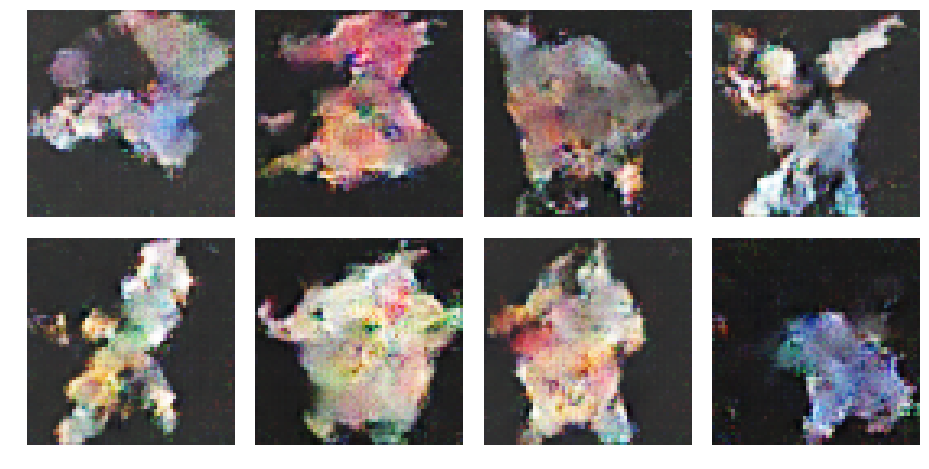

EPOCH:2001 EPOCH:2002 EPOCH:2003 EPOCH:2004 EPOCH:2005 EPOCH:2006 EPOCH:2007 EPOCH:2008 EPOCH:2009 EPOCH:2010 EPOCH:2011 EPOCH:2012 EPOCH:2013 EPOCH:2014 EPOCH:2015 EPOCH:2016 EPOCH:2017 EPOCH:2018 EPOCH:2019 EPOCH:2020 EPOCH:2021 EPOCH:2022 EPOCH:2023 EPOCH:2024 EPOCH:2025 EPOCH:2026 EPOCH:2027 EPOCH:2028 EPOCH:2029 EPOCH:2030 EPOCH:2031 EPOCH:2032 EPOCH:2033 EPOCH:2034 EPOCH:2035 EPOCH:2036 EPOCH:2037 EPOCH:2038 EPOCH:2039 EPOCH:2040 EPOCH:2041 EPOCH:2042 EPOCH:2043 EPOCH:2044 EPOCH:2045 EPOCH:2046 EPOCH:2047 EPOCH:2048 EPOCH:2049 EPOCH:2050 EPOCH:2051 EPOCH:2052 EPOCH:2053 EPOCH:2054 EPOCH:2055 EPOCH:2056 EPOCH:2057 EPOCH:2058 EPOCH:2059 EPOCH:2060 EPOCH:2061 EPOCH:2062 EPOCH:2063 EPOCH:2064 EPOCH:2065 EPOCH:2066 EPOCH:2067 EPOCH:2068 EPOCH:2069 EPOCH:2070 EPOCH:2071 EPOCH:2072 EPOCH:2073 EPOCH:2074 EPOCH:2075 EPOCH:2076 EPOCH:2077 EPOCH:2078 EPOCH:2079 EPOCH:2080 EPOCH:2081 EPOCH:2082 EPOCH:2083 EPOCH:2084 EPOCH:2085 EPOCH:2086 EPOCH:2087 EPOCH:2088 EPOCH:2089 EPOCH:2090 EPOCH:2091

EPOCH:2746 EPOCH:2747 EPOCH:2748 EPOCH:2749 EPOCH:2750 EPOCH:2751 EPOCH:2752 EPOCH:2753 EPOCH:2754 EPOCH:2755 EPOCH:2756 EPOCH:2757 EPOCH:2758 EPOCH:2759 EPOCH:2760 EPOCH:2761 EPOCH:2762 EPOCH:2763 EPOCH:2764 EPOCH:2765 EPOCH:2766 EPOCH:2767 EPOCH:2768 EPOCH:2769 EPOCH:2770 EPOCH:2771 EPOCH:2772 EPOCH:2773 EPOCH:2774 EPOCH:2775 EPOCH:2776 EPOCH:2777 EPOCH:2778 EPOCH:2779 EPOCH:2780 EPOCH:2781 EPOCH:2782 EPOCH:2783 EPOCH:2784 EPOCH:2785 EPOCH:2786 EPOCH:2787 EPOCH:2788 EPOCH:2789 EPOCH:2790 EPOCH:2791 EPOCH:2792 EPOCH:2793 EPOCH:2794 EPOCH:2795 EPOCH:2796 EPOCH:2797 EPOCH:2798 EPOCH:2799 EPOCH:2800 EPOCH:2801 EPOCH:2802 EPOCH:2803 EPOCH:2804 EPOCH:2805 EPOCH:2806 EPOCH:2807 EPOCH:2808 EPOCH:2809 EPOCH:2810 EPOCH:2811 EPOCH:2812 EPOCH:2813 EPOCH:2814 EPOCH:2815 EPOCH:2816 EPOCH:2817 EPOCH:2818 EPOCH:2819 EPOCH:2820 EPOCH:2821 EPOCH:2822 EPOCH:2823 EPOCH:2824 EPOCH:2825 EPOCH:2826 EPOCH:2827 EPOCH:2828 EPOCH:2829 EPOCH:2830 EPOCH:2831 EPOCH:2832 EPOCH:2833 EPOCH:2834 EPOCH:2835 EPOCH:2836

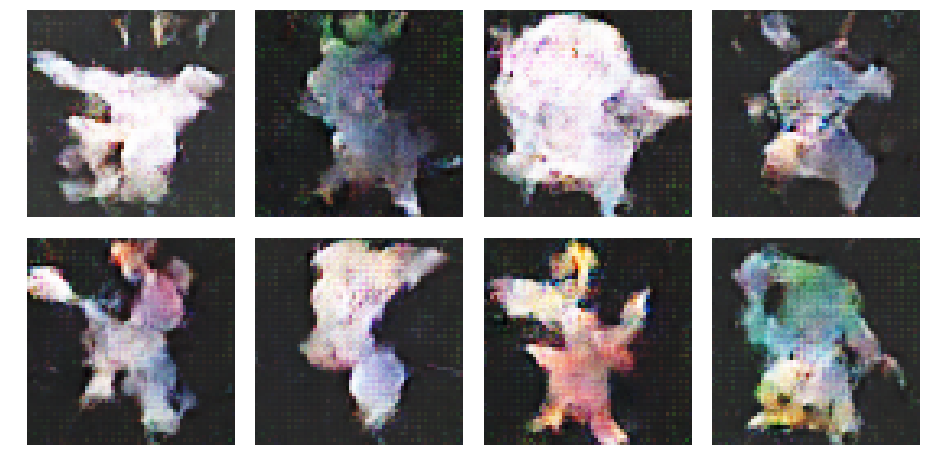

EPOCH:3001 EPOCH:3002 EPOCH:3003 EPOCH:3004 EPOCH:3005 EPOCH:3006 EPOCH:3007 EPOCH:3008 EPOCH:3009 EPOCH:3010 EPOCH:3011 EPOCH:3012 EPOCH:3013 EPOCH:3014 EPOCH:3015 EPOCH:3016 EPOCH:3017 EPOCH:3018 EPOCH:3019 EPOCH:3020 EPOCH:3021 EPOCH:3022 EPOCH:3023 EPOCH:3024 EPOCH:3025 EPOCH:3026 EPOCH:3027 EPOCH:3028 EPOCH:3029 EPOCH:3030 EPOCH:3031 EPOCH:3032 EPOCH:3033 EPOCH:3034 EPOCH:3035 EPOCH:3036 EPOCH:3037 EPOCH:3038 EPOCH:3039 EPOCH:3040 EPOCH:3041 EPOCH:3042 EPOCH:3043 EPOCH:3044 EPOCH:3045 EPOCH:3046 EPOCH:3047 EPOCH:3048 EPOCH:3049 EPOCH:3050 EPOCH:3051 EPOCH:3052 EPOCH:3053 EPOCH:3054 EPOCH:3055 EPOCH:3056 EPOCH:3057 EPOCH:3058 EPOCH:3059 EPOCH:3060 EPOCH:3061 EPOCH:3062 EPOCH:3063 EPOCH:3064 EPOCH:3065 EPOCH:3066 EPOCH:3067 EPOCH:3068 EPOCH:3069 EPOCH:3070 EPOCH:3071 EPOCH:3072 EPOCH:3073 EPOCH:3074 EPOCH:3075 EPOCH:3076 EPOCH:3077 EPOCH:3078 EPOCH:3079 EPOCH:3080 EPOCH:3081 EPOCH:3082 EPOCH:3083 EPOCH:3084 EPOCH:3085 EPOCH:3086 EPOCH:3087 EPOCH:3088 EPOCH:3089 EPOCH:3090 EPOCH:3091

EPOCH:3746 EPOCH:3747 EPOCH:3748 EPOCH:3749 EPOCH:3750 EPOCH:3751 EPOCH:3752 EPOCH:3753 EPOCH:3754 EPOCH:3755 EPOCH:3756 EPOCH:3757 EPOCH:3758 EPOCH:3759 EPOCH:3760 EPOCH:3761 EPOCH:3762 EPOCH:3763 EPOCH:3764 EPOCH:3765 EPOCH:3766 EPOCH:3767 EPOCH:3768 EPOCH:3769 EPOCH:3770 EPOCH:3771 EPOCH:3772 EPOCH:3773 EPOCH:3774 EPOCH:3775 EPOCH:3776 EPOCH:3777 EPOCH:3778 EPOCH:3779 EPOCH:3780 EPOCH:3781 EPOCH:3782 EPOCH:3783 EPOCH:3784 EPOCH:3785 EPOCH:3786 EPOCH:3787 EPOCH:3788 EPOCH:3789 EPOCH:3790 EPOCH:3791 EPOCH:3792 EPOCH:3793 EPOCH:3794 EPOCH:3795 EPOCH:3796 EPOCH:3797 EPOCH:3798 EPOCH:3799 EPOCH:3800 EPOCH:3801 EPOCH:3802 EPOCH:3803 EPOCH:3804 EPOCH:3805 EPOCH:3806 EPOCH:3807 EPOCH:3808 EPOCH:3809 EPOCH:3810 EPOCH:3811 EPOCH:3812 EPOCH:3813 EPOCH:3814 EPOCH:3815 EPOCH:3816 EPOCH:3817 EPOCH:3818 EPOCH:3819 EPOCH:3820 EPOCH:3821 EPOCH:3822 EPOCH:3823 EPOCH:3824 EPOCH:3825 EPOCH:3826 EPOCH:3827 EPOCH:3828 EPOCH:3829 EPOCH:3830 EPOCH:3831 EPOCH:3832 EPOCH:3833 EPOCH:3834 EPOCH:3835 EPOCH:3836

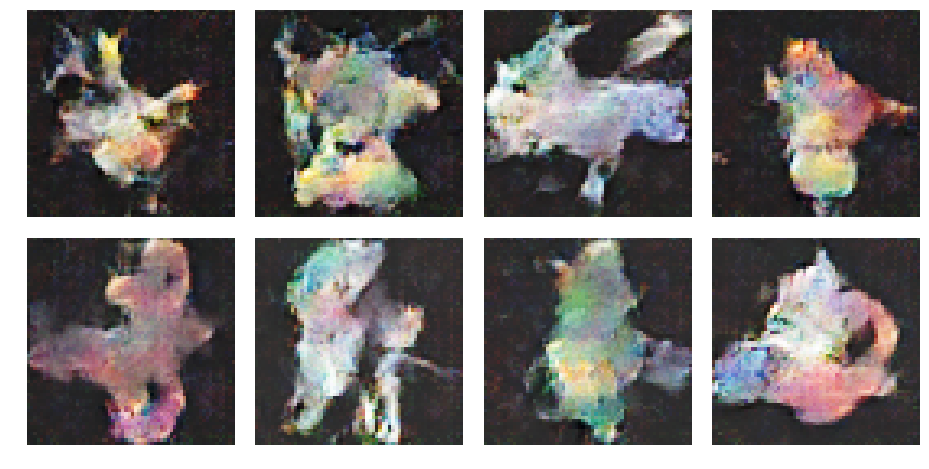

EPOCH:4001 EPOCH:4002 EPOCH:4003 EPOCH:4004 EPOCH:4005 EPOCH:4006 EPOCH:4007 EPOCH:4008 EPOCH:4009 EPOCH:4010 EPOCH:4011 EPOCH:4012 EPOCH:4013 EPOCH:4014 EPOCH:4015 EPOCH:4016 EPOCH:4017 EPOCH:4018 EPOCH:4019 EPOCH:4020 EPOCH:4021 EPOCH:4022 EPOCH:4023 EPOCH:4024 EPOCH:4025 EPOCH:4026 EPOCH:4027 EPOCH:4028 EPOCH:4029 EPOCH:4030 EPOCH:4031 EPOCH:4032 EPOCH:4033 EPOCH:4034 EPOCH:4035 EPOCH:4036 EPOCH:4037 EPOCH:4038 EPOCH:4039 EPOCH:4040 EPOCH:4041 EPOCH:4042 EPOCH:4043 EPOCH:4044 EPOCH:4045 EPOCH:4046 EPOCH:4047 EPOCH:4048 EPOCH:4049 EPOCH:4050 EPOCH:4051 EPOCH:4052 EPOCH:4053 EPOCH:4054 EPOCH:4055 EPOCH:4056 EPOCH:4057 EPOCH:4058 EPOCH:4059 EPOCH:4060 EPOCH:4061 EPOCH:4062 EPOCH:4063 EPOCH:4064 EPOCH:4065 EPOCH:4066 EPOCH:4067 EPOCH:4068 EPOCH:4069 EPOCH:4070 EPOCH:4071 EPOCH:4072 EPOCH:4073 EPOCH:4074 EPOCH:4075 EPOCH:4076 EPOCH:4077 EPOCH:4078 EPOCH:4079 EPOCH:4080 EPOCH:4081 EPOCH:4082 EPOCH:4083 EPOCH:4084 EPOCH:4085 EPOCH:4086 EPOCH:4087 EPOCH:4088 EPOCH:4089 EPOCH:4090 EPOCH:4091

EPOCH:4746 EPOCH:4747 EPOCH:4748 EPOCH:4749 EPOCH:4750 EPOCH:4751 EPOCH:4752 EPOCH:4753 EPOCH:4754 EPOCH:4755 EPOCH:4756 EPOCH:4757 EPOCH:4758 EPOCH:4759 EPOCH:4760 EPOCH:4761 EPOCH:4762 EPOCH:4763 EPOCH:4764 EPOCH:4765 EPOCH:4766 EPOCH:4767 EPOCH:4768 EPOCH:4769 EPOCH:4770 EPOCH:4771 EPOCH:4772 EPOCH:4773 EPOCH:4774 EPOCH:4775 EPOCH:4776 EPOCH:4777 EPOCH:4778 EPOCH:4779 EPOCH:4780 EPOCH:4781 EPOCH:4782 EPOCH:4783 EPOCH:4784 EPOCH:4785 EPOCH:4786 EPOCH:4787 EPOCH:4788 EPOCH:4789 EPOCH:4790 EPOCH:4791 EPOCH:4792 EPOCH:4793 EPOCH:4794 EPOCH:4795 EPOCH:4796 EPOCH:4797 EPOCH:4798 EPOCH:4799 EPOCH:4800 EPOCH:4801 EPOCH:4802 EPOCH:4803 EPOCH:4804 EPOCH:4805 EPOCH:4806 EPOCH:4807 EPOCH:4808 EPOCH:4809 EPOCH:4810 EPOCH:4811 EPOCH:4812 EPOCH:4813 EPOCH:4814 EPOCH:4815 EPOCH:4816 EPOCH:4817 EPOCH:4818 EPOCH:4819 EPOCH:4820 EPOCH:4821 EPOCH:4822 EPOCH:4823 EPOCH:4824 EPOCH:4825 EPOCH:4826 EPOCH:4827 EPOCH:4828 EPOCH:4829 EPOCH:4830 EPOCH:4831 EPOCH:4832 EPOCH:4833 EPOCH:4834 EPOCH:4835 EPOCH:4836

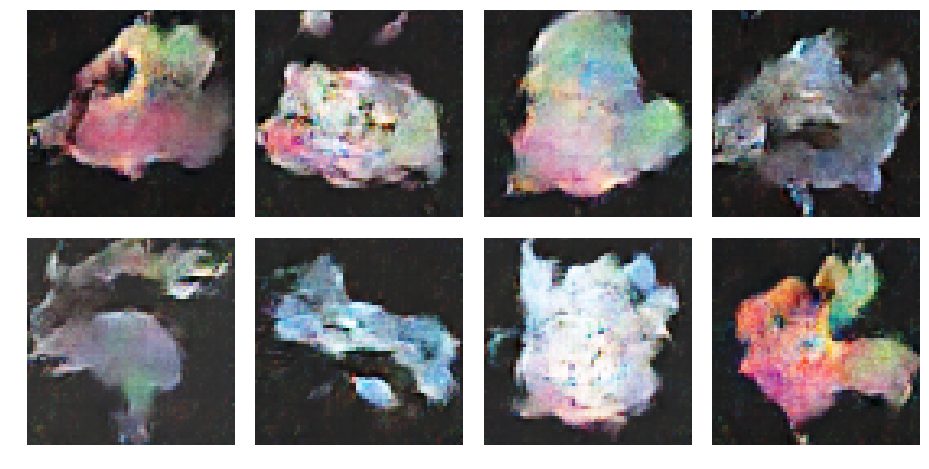

In [38]:
init = tf.global_variables_initializer()

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    
    if continuous: saver.restore(sess, tf.train.latest_checkpoint(CK_DIR))
    
    for e in range(n_epochs):
        print("EPOCH:{}".format(e+1), end=' ')
 
        for real_im, real_y in get_batch(images, batch_size, repeat=item_repeat):

            z_noise = np.random.normal(size=(batch_size*item_repeat,noise_dim))
            y_ones_val = np.random.uniform(0.7, 1.2, real_y.shape)
            y_zeros_val = np.random.uniform(0.0, 0.3, real_y.shape)
            
            _, _ = sess.run([disc_train_op, gen_train_op], feed_dict={
                z: z_noise,
                real_image: real_im,
                y_ones: y_ones_val,
                y_zeros: y_zeros_val
            })

        if (e+1) % view_for_every == 0:
            saver.save(sess, os.path.join(CK_DIR, 'pokemon.ckpt'), write_meta_graph=False)
            gen_loss_v, disc_loss_v = sess.run([gen_loss, disc_loss], feed_dict={
                z: z_noise,
                real_image: real_im,
                y_ones: y_ones_val,
                y_zeros: y_zeros_val,
            })

            print("\n{}/{}: gen_loss:{}, disc_loss:{}".format(e+1, n_epochs, gen_loss_v, disc_loss_v))


            fake_im = sess.run(gen(z, reuse=True, train=False), feed_dict={z:np.random.normal(size=(8,noise_dim))})

            fig, axes = plt.subplots(figsize=(16,8), nrows=2, ncols=4, sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax, img in zip(axes.flatten(), fake_im):
                ax.axis('off')
                img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
                im = ax.imshow(img)
            plt.show()


INFO:tensorflow:Restoring parameters from /output/pokemon/pokemon.ckpt


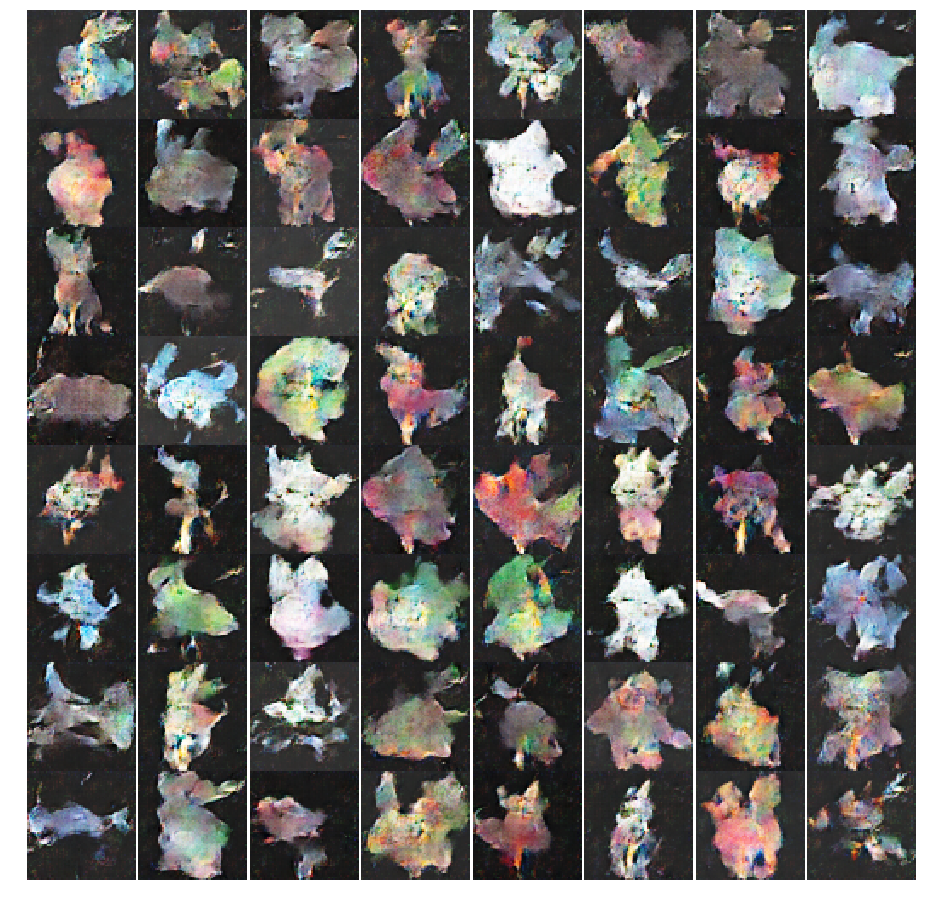

In [42]:
global_id = len(os.listdir(OUTPUT_DIR))
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(CK_DIR))
    fake_ims = sess.run(gen(z, reuse=True, train=False), feed_dict={z:np.random.normal(size=(64,noise_dim))})
    fig, axes = plt.subplots(figsize=(16,16), nrows=8, ncols=8, sharey=True, sharex=True)
    plt.subplots_adjust(wspace=-0.01, hspace=0)
    for ax, img in zip(axes.flatten(), fake_ims):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        im = ax.imshow(img)
        im_obj = Image.fromarray((img * 255).astype(np.uint8))
        im_obj.save('{}{}.png'.format(OUTPUT_DIR, global_id))
        global_id += 1
    plt.show()

